# GoodsForecast.OSA – Определение наличия товаров на полке в интервалах без продаж · Направление 2

### Описание кейса

Система GoodsForecast.OSA* анализирует историю продаж в сети магазинов и определяет товары с наибольшей вероятностью отсутствия на полке.    
Сотрудники магазинов по каждой позиции проверяют наличие товара и корректность ценника, при необходимости выставляя продукцию со склада и/или корректируя ценник.    
Таким образом, мы стремимся обеспечить своевременное обнаружение отсутствия товаров на полке, чтобы покупатели не упустили возможность совершить покупку, а сеть повысила товарооборот.

**Задача:** Вам необходимо решить задачу бинарной классификации – определение наличия товаров на полке в интервалах без продаж с оценкой производительности по метрике AUC-ROC.

 Заказчиком был предоставлен к следующим таблицам в БД (microsoft sql):    
1) dbo.Features - основной датасет состоящий из столбцов с магазинами, товарами, датой получения информации о наличии товара на полке, вероятность отсутствия, истинный результат (1 - отсутствие) и столбцы признаков.   
2) dbo.LocationStateHourSales - статистика ежечасных продаж товаров по магазинам       
3) dbo.LocationStateStocks - информация по остаткам товаров в магазинах<br>

Для записей из dbo.Features с отсутствующими значениями IsCorrect (отсутствия товара) нужно предсказать.

## Формат выгрузки csv-файла (столбцы):
### Для чек-поинтов - это на тренировочных данных, для финального резульата - на тестовых данных

1.   LocationId
2.   ProductId
3.   ValidationDateTime
4.   CalculatedProbability (вычисленная вами вероятность - predict_proba() )

## План работы:

 1. Загрузка и изучение данных.       
 2. Предобработка данных
   + проверим дубликаты
   + разделим трейн по условию задачи
   + удаление констант и пустых столбцов
   + изменение типов данных
   + заполним пропуски
   + удаление дублирующих столбцов
 3. Обучение моделей
   + Random Forest
   + Cat Boost
 4. Создание новых фичей
 5. feature_selection
 6. Обучение финальной модели
 7. Предсказание на тесте

In [1]:
!pip install -q catboost
!pip install -q plotly
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

from lightgbm import LGBMClassifier

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# округляем значения до трех знаков после запятой
pd.options.display.float_format = '{:.6f}'.format

STATE=42

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
TRAIN='/content/gdrive/MyDrive/GoodsForecastHack/train_df.csv'
TEST_FINAL='/content/gdrive/MyDrive/GoodsForecastHack/test_df.csv'
SALES='/content/gdrive/MyDrive/GoodsForecastHack/sales.csv'
SALES_FULL='/content/gdrive/MyDrive/GoodsForecastHack/LocationStateHourSales.csv'
STOCKS='/content/gdrive/MyDrive/GoodsForecastHack/stocks.csv'
STOCKS_FULL='/content/gdrive/MyDrive/GoodsForecastHack/LocationStateStocks.csv'

In [4]:
# Параметры подключеия к базе

# conn_str = """
#     Driver={ODBC Driver 17 for SQL Server};
#     Server=109.71.11.235;
#     Database=GFC.Hackathon;
#     UID=participant;
#     PWD=AiNRYmEatiBL;
# """

# conn = pyodbc.connect(conn_str)

In [5]:
# пример запросов - здесь выведен весь датасет признаков
# query_features = "select * from dbo.Features"
# df = pd.read_sql(query_features, conn)

- ### для обучения модели используем записи с IsCorrect is not null   
- ### тестовая выборка (то, что используется в финальном зачете) - записи с IsCorrect is null      
- ### дополнительные таблицы с почасовыми продажами и остатками sales и stocks    
- ### csv-файл для промежуточных результатов должен быть за следующие даты ('ValidationDateTime >= "2023-07-15"')

## Загрузка и изучение данных.

In [6]:
# для обучения модели используем записи с IsCorrect is not null
if os.path.exists(TRAIN):
    train_df = pd.read_csv(TRAIN)
else:
    print('Nothing works.')

In [7]:
# тестовая выборка (то, что используется в финальном зачете) - записи с IsCorrect is null
if os.path.exists(TEST_FINAL):
    test_final = pd.read_csv(TEST_FINAL)
else:
    print('Nothing works.')

In [8]:
train_df.head(3)

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07.000,0.416474,False,86.000000,85.000000,0.011628,NaN,NaN,0.142857,2,NaN,14.990000,14.990000,0.000000,0.000000,1.000000,True,NaN,-1.000000,NaN,142.000000,19,28,NaN,1.367042,NaN,0.047139,14.990000,14.990000,14.990000,14.990000,0.000000,1.000000,116.000000,1738.839966,14.990000,14.990000,0.000000,0.000000,0.000000,0.000000,0.000000,True,True,False,1.000000,1.000000,0.000000,1.000000,14.990000,14.990000,14.990000,14.990000,14.990000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000
1,63,288606,2023-06-01 15:32:31.000,0.687710,False,8.000000,7.000000,0.125000,NaN,NaN,3.714286,19,NaN,29.990000,29.990000,0.000000,0.000000,1.000000,False,4.000000,3.000000,1.000000,15.000000,19,28,NaN,6.573534,0.931035,0.226674,29.854864,29.941101,29.990000,27.389999,0.086696,0.415254,20060.000000,600618.500000,29.990000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,False,True,True,0.000000,1.000000,-1.000000,0.000000,29.990000,29.990000,29.990000,29.990000,29.990000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000
2,63,288606,2023-06-03 12:55:49.000,0.810382,False,10.000000,9.000000,0.100000,NaN,NaN,3.214286,19,NaN,29.990000,29.990000,0.000000,0.000000,1.000000,False,6.000000,5.000000,1.000000,11.000000,16,25,NaN,5.946440,0.923077,0.228709,29.848429,29.937546,29.990000,27.389999,0.086696,0.445455,18700.000000,559832.125000,29.990000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,False,True,True,0.000000,1.000000,-1.000000,0.000000,29.990000,29.990000,29.990000,29.990000,29.990000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.000000


In [9]:
print('Количество магазинов:', train_df['LocationId'].nunique())
print('Количество товаров:', train_df['ProductId'].nunique())

Количество магазинов: 323
Количество товаров: 3156


False   0.770403
True    0.229597
Name: IsCorrect, dtype: float64


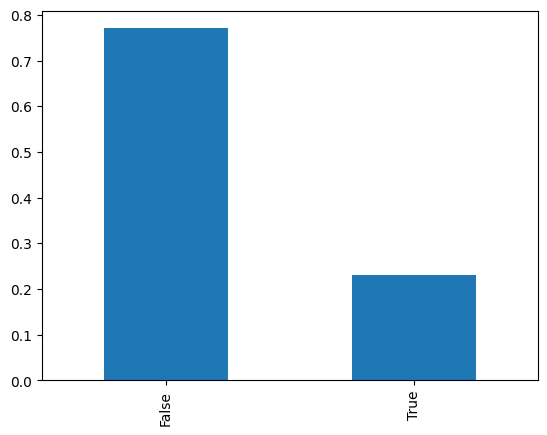

In [10]:
# посмотрим на распределение таргета
print(train_df.IsCorrect.value_counts(normalize=1))
train_df.IsCorrect.value_counts(normalize=1).plot(kind='bar');

## Предобработка данных

In [11]:
# при скачивании данных видимо произошла ошибка и данные скачались с секундами в формате float
# преобразуем дату в корректный формат
train_df['ValidationDateTime'] = pd.to_datetime(train_df['ValidationDateTime']).dt.round('S')
test_final['ValidationDateTime'] = pd.to_datetime(test_final['ValidationDateTime']).dt.round('S')

In [12]:
# отсортируем фреймы по датам
train_df.sort_values('ValidationDateTime', inplace=True)
test_final.sort_values('ValidationDateTime', inplace=True)

In [13]:
# для удобства напишем функцию для просмотра информации о датафрейме
def description(df):
    frame = df.dtypes.to_frame(name='Тип данных')
    frame['Кол-во пропусков'] = df.isna().sum()
    frame['Процент пропусков'] = df.isna().mean() * 100
    frame['Кол-во уникальных'] = df.nunique()
    frame['MIN'] = df.min()
    frame['Медиана'] = df.median()
    frame['MAX'] = df.max()
    frame['STD'] = df.std()
    return frame

In [14]:
# посмотрим на данные
description(train_df)

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
LocationId,int64,0,0.000000,323,63,1736.000000,2950,887.816815
ProductId,int64,0,0.000000,3156,288312,425848.000000,576749,79773.753520
ValidationDateTime,datetime64[ns],0,0.000000,50405,2023-06-01 14:44:35,NaN,2023-07-21 17:22:27,14 days 01:04:07.911169536
Probability,float64,180,0.132502,44688,-1.000000,0.755140,1.000000,0.350718
IsCorrect,bool,0,0.000000,2,False,0.000000,True,0.420575
Column6,float64,0,0.000000,90,0.000000,3.000000,89.000000,8.272221
Column7,float64,0,0.000000,92,-2.000000,2.000000,89.000000,8.275806
Column8,float64,28017,20.623937,100,0.000000,0.250000,2.000000,0.379249
Column9,float64,135847,100.000000,0,NaN,NaN,NaN,NaN
Column10,float64,135847,100.000000,0,NaN,NaN,NaN,NaN


В данных наблюдаются выбросы и пропущенные значения + 1 строка с большим кол-вом пропусков

#### Проверим дубликаты

In [15]:
train_df.duplicated().sum()

0

#### Разделим трейн по условию задачи на трейн и промежуточный тест (ValidationDateTime >= "2023-07-15)

In [16]:
train_df.shape

(135847, 66)

In [17]:
train = train_df[train_df['ValidationDateTime'] < '2023-07-15']
test = train_df[train_df['ValidationDateTime'] >= '2023-07-15']

In [18]:
train.shape, test.shape

((110912, 66), (24935, 66))

#### Удаление констант и пустых столбцов

In [19]:
# создадим список столбцов с константными значениями
col_const = [col for col in train.columns if train[col].nunique() == 1]
col_const

['Column58',
 'Column59',
 'Column60',
 'Column61',
 'Column62',
 'Column63',
 'Column64',
 'Column65',
 'Column67']

In [20]:
# создадим список столбцов со 100% пропусками
col_na_100 = [col for col in train.columns if train[col].isna().mean() == 1]
col_na_100

['Column9', 'Column10', 'Column26', 'Column66']

In [21]:
col_drop = col_na_100 + col_const
col_drop

['Column9',
 'Column10',
 'Column26',
 'Column66',
 'Column58',
 'Column59',
 'Column60',
 'Column61',
 'Column62',
 'Column63',
 'Column64',
 'Column65',
 'Column67']

In [22]:
# удалим эти столбцы
train = train.drop(col_drop, axis=1)
test = test.drop(col_drop, axis=1)
test_final = test_final.drop(col_drop, axis=1)

In [23]:
train.shape, test.shape, test_final.shape

((110912, 53), (24935, 53), (40771, 53))

In [24]:
# взглянем ешё раз
description(train)

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
LocationId,int64,0,0.000000,318,63,1736.000000,2950,891.074678
ProductId,int64,0,0.000000,2967,288525,425847.000000,576661,79927.065613
ValidationDateTime,datetime64[ns],0,0.000000,41921,2023-06-01 14:44:35,NaN,2023-07-14 17:29:33,12 days 07:25:31.835091999
Probability,float64,12,0.010819,37256,-1.000000,0.755140,1.000000,0.352926
IsCorrect,bool,0,0.000000,2,False,0.000000,True,0.370649
Column6,float64,0,0.000000,90,0.000000,3.000000,89.000000,8.135927
Column7,float64,0,0.000000,92,-2.000000,2.000000,89.000000,8.137644
Column8,float64,23686,21.355669,100,0.000000,0.250000,2.000000,0.378563
Column11,float64,0,0.000000,1946,0.035714,3.500000,386.107147,4.677657
Column12,int64,0,0.000000,29,0,22.000000,28,6.043953


In [25]:
train[train.Column30.isna()]

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57
85766,2160,500701,2023-06-05 15:26:34,0.976585,True,20.000000,20.000000,0.000000,0.857143,0,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0.000000,NaN,39.000000,14,13,0.702608,NaN,0.050186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Изменение типов данных

In [26]:
cat_col = train.select_dtypes(include=['object', 'bool']).columns.tolist()
cat_col

['IsCorrect', 'Column19', 'Column45', 'Column46', 'Column47']

In [27]:
# посмотрим на уникальные значения столбцов с типом object и bool
for col in train[cat_col]:
    print(train[col].value_counts())
    print(test[col].value_counts())
    print(test_final[col].value_counts(), '\n')

False    92677
True     18235
Name: IsCorrect, dtype: int64
True     12955
False    11980
Name: IsCorrect, dtype: int64
Series([], Name: IsCorrect, dtype: int64) 

False    55582
True     55330
Name: Column19, dtype: int64
True     13316
False    11619
Name: Column19, dtype: int64
False    22095
True     18676
Name: Column19, dtype: int64 

False    55558
True     55353
Name: Column45, dtype: int64
True     13265
False    11670
Name: Column45, dtype: int64
False    21596
True     19175
Name: Column45, dtype: int64 

False    69465
True     40778
Name: Column46, dtype: int64
False    15402
True      9404
Name: Column46, dtype: int64
False    24254
True     16195
Name: Column46, dtype: int64 

False    67350
True     43561
Name: Column47, dtype: int64
False    15798
True      9137
Name: Column47, dtype: int64
False    25313
True     15458
Name: Column47, dtype: int64 



In [28]:
# преобразуем их в int и float
for col in train[cat_col]:
    train[col] = train[col]*1
    test[col] = test[col]*1
    test_final[col] = test_final[col]*1

In [29]:
for col in train[cat_col]:
    print(train[col].value_counts())
    print(test[col].value_counts())
    print(test_final[col].value_counts(), '\n')

0    92677
1    18235
Name: IsCorrect, dtype: int64
1    12955
0    11980
Name: IsCorrect, dtype: int64
Series([], Name: IsCorrect, dtype: int64) 

0    55582
1    55330
Name: Column19, dtype: int64
1    13316
0    11619
Name: Column19, dtype: int64
0    22095
1    18676
Name: Column19, dtype: int64 

0    55558
1    55353
Name: Column45, dtype: int64
1    13265
0    11670
Name: Column45, dtype: int64
0    21596
1    19175
Name: Column45, dtype: int64 

0    69465
1    40778
Name: Column46, dtype: int64
0    15402
1     9404
Name: Column46, dtype: int64
0    24254
1    16195
Name: Column46, dtype: int64 

0    67350
1    43561
Name: Column47, dtype: int64
0    15798
1     9137
Name: Column47, dtype: int64
0    25313
1    15458
Name: Column47, dtype: int64 



### Заполним пропуски

In [30]:
# создадим список столбцов с пропущенными значениями
col_na = [col for col in train.columns if train[col].isna().sum() > 0]

In [31]:
# заполним пропуски медианой
%%time
imputer = SimpleImputer(strategy='median')
train[col_na] = imputer.fit_transform(train[col_na])
test[col_na] = imputer.transform(test[col_na])
test_final[col_na] = imputer.transform(test_final[col_na])

CPU times: user 3.04 s, sys: 936 ms, total: 3.98 s
Wall time: 5.36 s


In [32]:
train.isna().sum().sum(), test.isna().sum().sum(), test_final.isna().sum().sum()

(0, 0, 40771)

In [33]:
test_final.isna().sum()

LocationId                0
ProductId                 0
ValidationDateTime        0
Probability               0
IsCorrect             40771
Column6                   0
Column7                   0
Column8                   0
Column11                  0
Column12                  0
Column13                  0
Column14                  0
Column15                  0
Column16                  0
Column17                  0
Column18                  0
Column19                  0
Column20                  0
Column21                  0
Column22                  0
Column23                  0
Column24                  0
Column25                  0
Column27                  0
Column28                  0
Column29                  0
Column30                  0
Column31                  0
Column32                  0
Column33                  0
Column34                  0
Column35                  0
Column36                  0
Column37                  0
Column38                  0
Column39            

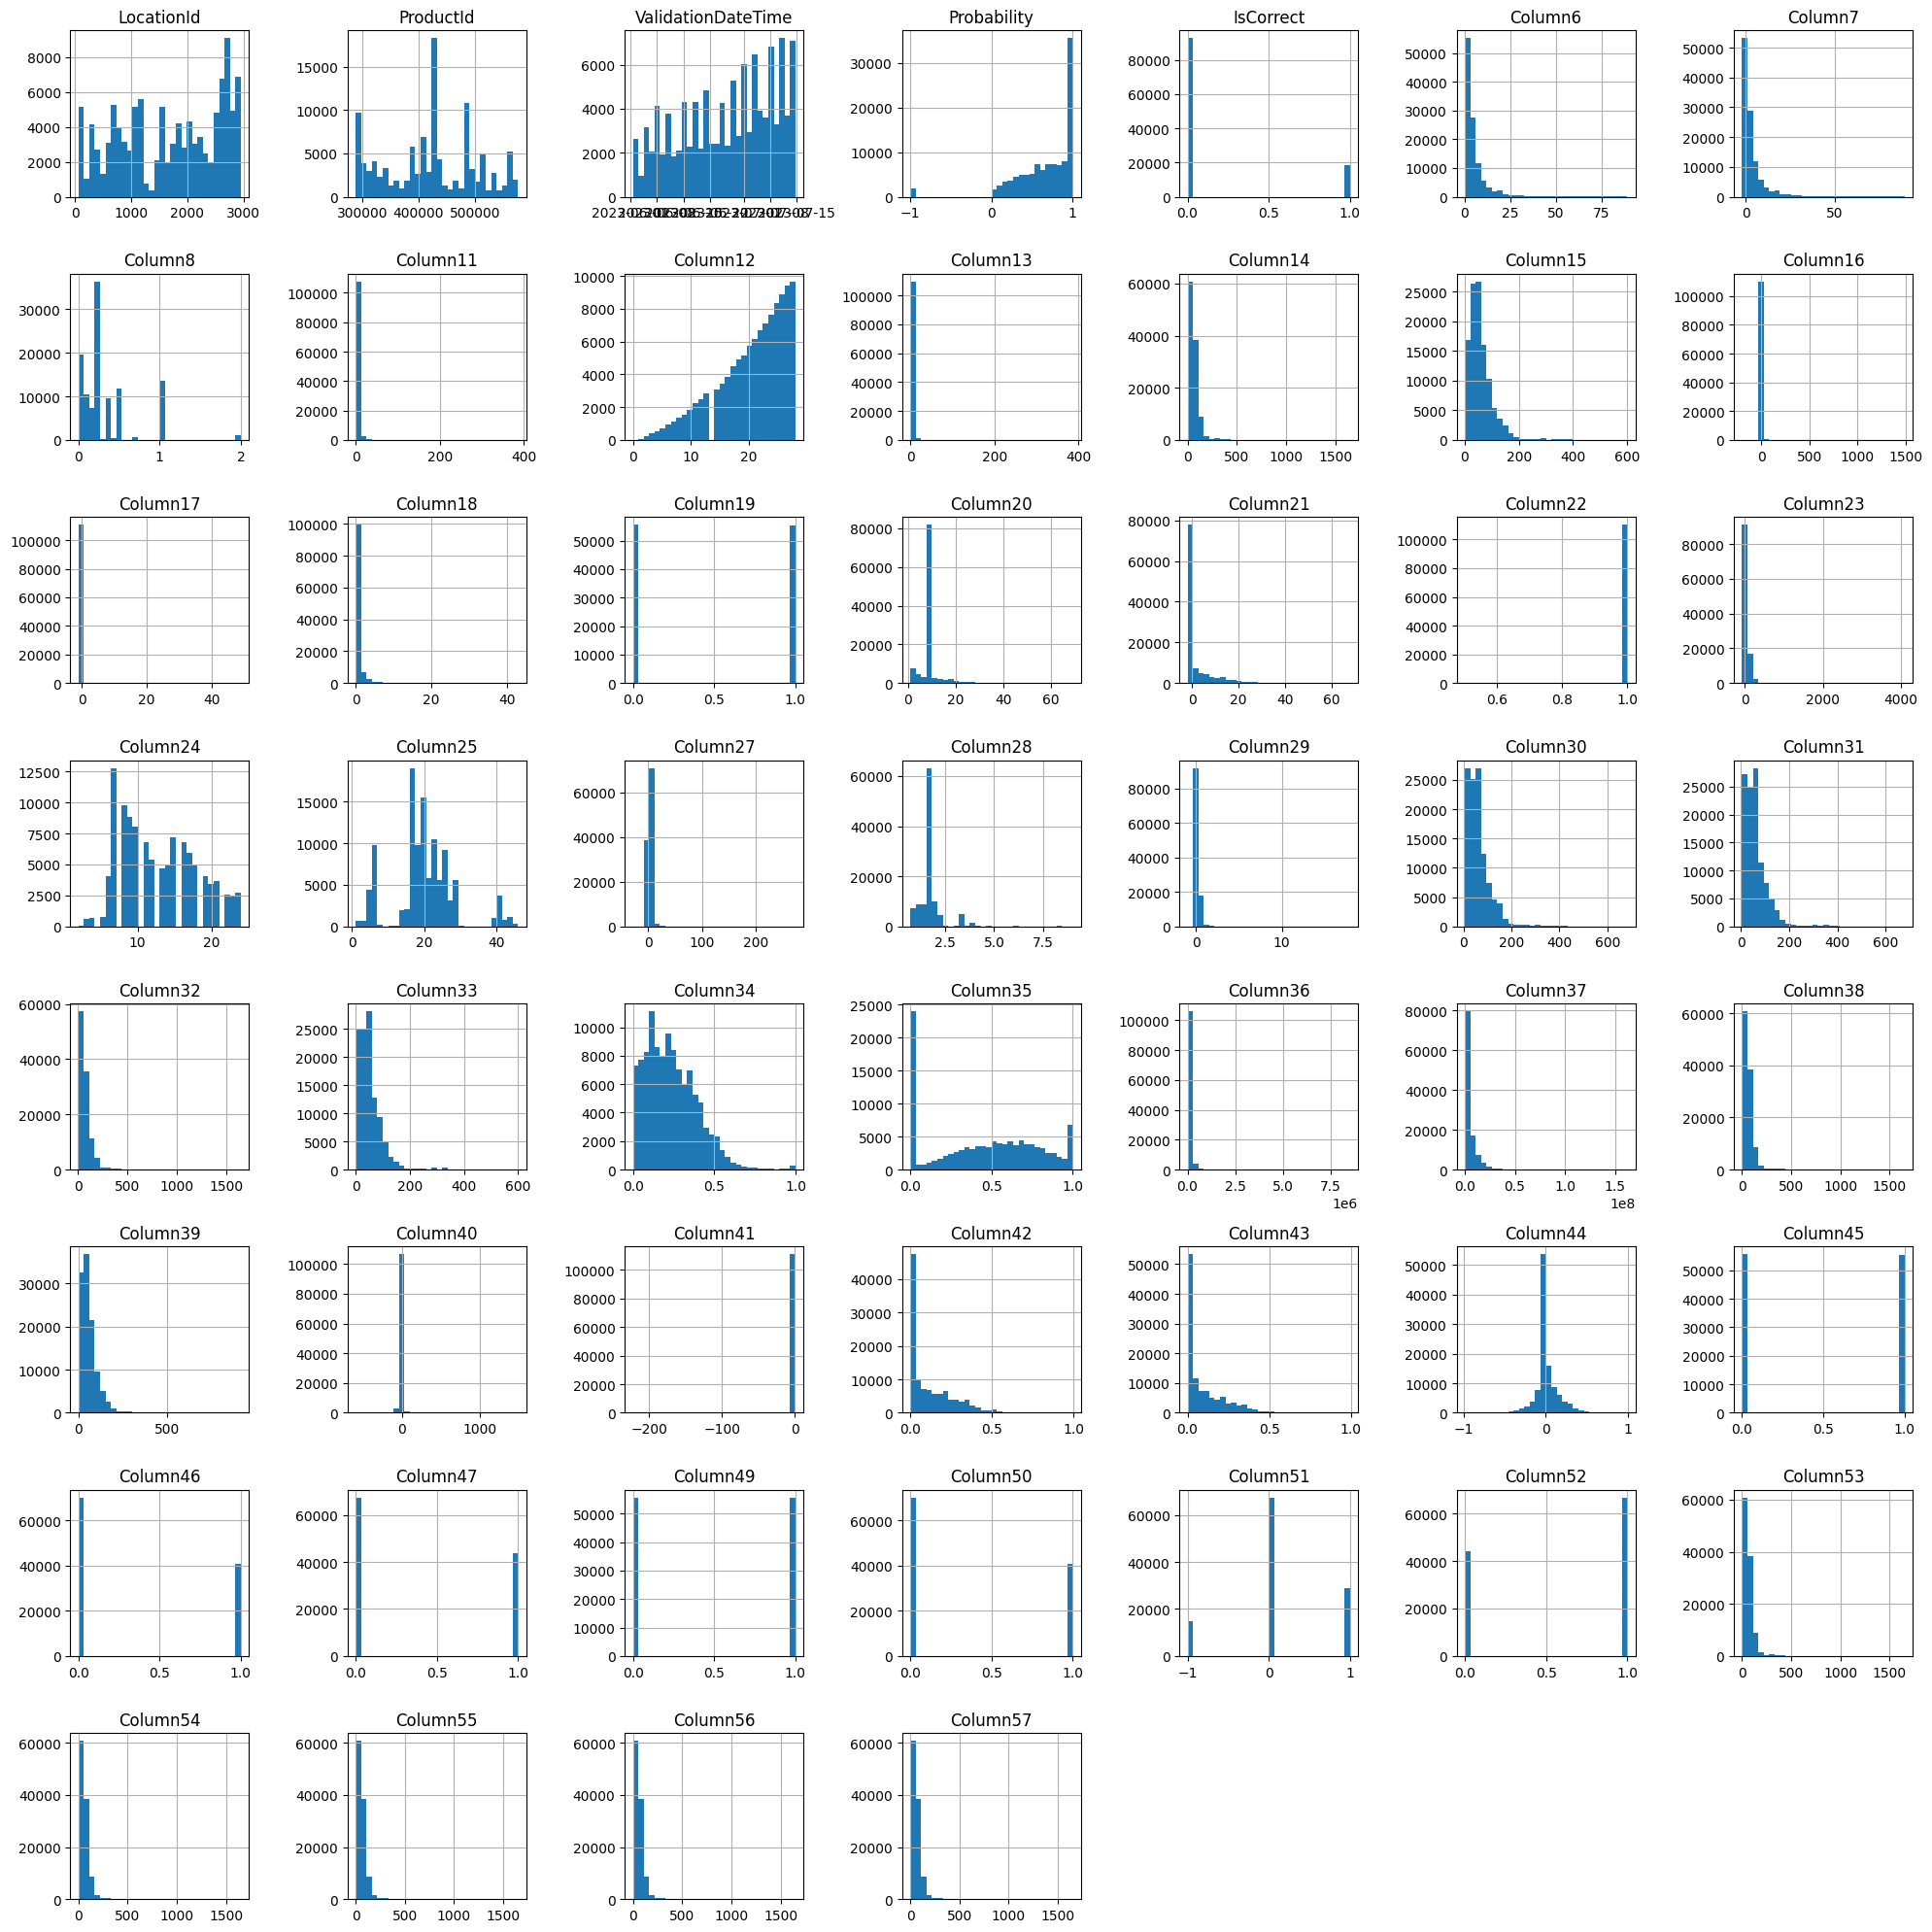

In [34]:
# строим гистограммы для всего датафрейма
train.hist(figsize=(20, 20), bins=30)
plt.tight_layout()

In [35]:
description(train)

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
LocationId,int64,0,0.000000,318,63,1736.000000,2950,891.074678
ProductId,int64,0,0.000000,2967,288525,425847.000000,576661,79927.065613
ValidationDateTime,datetime64[ns],0,0.000000,41921,2023-06-01 14:44:35,NaN,2023-07-14 17:29:33,12 days 07:25:31.835091999
Probability,float64,0,0.000000,37256,-1.000000,0.755140,1.000000,0.352908
IsCorrect,int64,0,0.000000,2,0,0.000000,1,0.370649
Column6,float64,0,0.000000,90,0.000000,3.000000,89.000000,8.135927
Column7,float64,0,0.000000,92,-2.000000,2.000000,89.000000,8.137644
Column8,float64,0,0.000000,100,0.000000,0.250000,2.000000,0.338382
Column11,float64,0,0.000000,1946,0.035714,3.500000,386.107147,4.677657
Column12,int64,0,0.000000,29,0,22.000000,28,6.043953


**На гистограммах и в таблице описания столбцов мы видим дубликаты. Сравним их и при небходимости избавимся от них.**

### Удаление дублирующих столбцов.

In [36]:
tmp_train = description(train)

In [37]:
tmp_train[tmp_train.duplicated(keep=False)]

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
Column14,float64,0,0.000000,24812,0.200000,51.101112,1650.000000,48.730208
Column38,float64,0,0.000000,24812,0.200000,51.101112,1650.000000,48.730208
Column45,float64,0,0.000000,2,0.000000,0.000000,1.000000,0.500001
Column46,float64,0,0.000000,2,0.000000,0.000000,1.000000,0.482171
Column49,float64,0,0.000000,2,0.000000,0.000000,1.000000,0.500001
Column50,float64,0,0.000000,2,0.000000,0.000000,1.000000,0.482171
Column53,float64,0,0.000000,24812,0.200000,51.101112,1650.000000,48.730208
Column54,float64,0,0.000000,24812,0.200000,51.101112,1650.000000,48.730208
Column55,float64,0,0.000000,24812,0.200000,51.101112,1650.000000,48.730208
Column56,float64,0,0.000000,24812,0.200000,51.101112,1650.000000,48.730208


In [38]:
col_dup_train = tmp_train[tmp_train.duplicated()].index.tolist()
col_dup_train

['Column38',
 'Column49',
 'Column50',
 'Column53',
 'Column54',
 'Column55',
 'Column56',
 'Column57']

И на всякий случай проверим эти столбцы ещё раз)))

In [39]:
# Создаем пустой список для хранения списков столбцов, которые равны друг другу
equal_columns = []

# Сравниваем каждую пару столбцов на равенство
columns = train.columns
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        if (train[columns[i]] == train[columns[j]]).all():
            equal_columns.append([columns[i], columns[j]])

In [40]:
print("Список списков столбцов, которые равны друг другу:")
for columns in equal_columns:
    print(columns)

Список списков столбцов, которые равны друг другу:
['Column14', 'Column38']
['Column14', 'Column53']
['Column14', 'Column54']
['Column14', 'Column55']
['Column14', 'Column56']
['Column14', 'Column57']
['Column38', 'Column53']
['Column38', 'Column54']
['Column38', 'Column55']
['Column38', 'Column56']
['Column38', 'Column57']
['Column45', 'Column49']
['Column46', 'Column50']
['Column53', 'Column54']
['Column53', 'Column55']
['Column53', 'Column56']
['Column53', 'Column57']
['Column54', 'Column55']
['Column54', 'Column56']
['Column54', 'Column57']
['Column55', 'Column56']
['Column55', 'Column57']
['Column56', 'Column57']


**Также проверим являются ли эти столбцы дублирующими в test и test_final**

In [41]:
tmp_test = description(test)

In [42]:
tmp_test[tmp_test.duplicated(keep=False)]

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
Column14,float64,0,0.000000,6760,1.000000,49.990002,599.906921,50.371120
Column38,float64,0,0.000000,6760,1.000000,49.990002,599.906921,50.371120
Column45,float64,0,0.000000,2,0.000000,1.000000,1.000000,0.498986
Column46,float64,0,0.000000,2,0.000000,0.000000,1.000000,0.484680
Column49,float64,0,0.000000,2,0.000000,1.000000,1.000000,0.498986
Column50,float64,0,0.000000,2,0.000000,0.000000,1.000000,0.484680
Column53,float64,0,0.000000,6760,1.000000,49.990002,599.906921,50.371120
Column54,float64,0,0.000000,6760,1.000000,49.990002,599.906921,50.371120
Column55,float64,0,0.000000,6760,1.000000,49.990002,599.906921,50.371120
Column56,float64,0,0.000000,6760,1.000000,49.990002,599.906921,50.371120


In [43]:
col_dup_test = tmp_test[tmp_test.duplicated()].index.tolist()

In [44]:
# одинаковы ли дублирующие столбцы в train и test
col_dup_train == col_dup_test

True

In [45]:
tmp_test_final = description(test_final)

In [46]:
col_dup_test_final = tmp_test_final[tmp_test_final.duplicated()].index.tolist()

In [47]:
# одинаковы ли дублирующие столбцы в test и test_final
col_dup_test == col_dup_test_final

True

In [48]:
train.shape, test.shape, test_final.shape

((110912, 53), (24935, 53), (40771, 53))

In [49]:
# удалим эти столбцы
train = train.drop(col_dup_train, axis=1)
test = test.drop(col_dup_train, axis=1)
test_final = test_final.drop(col_dup_train, axis=1)

In [50]:
train.shape, test.shape, test_final.shape

((110912, 45), (24935, 45), (40771, 45))

## Обучение моделей

### Добавим столбец с числовым выражение даты

In [51]:
train['date_time_int'] = train['ValidationDateTime'].apply(lambda x: x.toordinal())
test['date_time_int'] = test['ValidationDateTime'].apply(lambda x: x.toordinal())
test_final['date_time_int'] = test_final['ValidationDateTime'].apply(lambda x: x.toordinal())

In [52]:
# список столбцов для обучения
X_col = train.drop(columns=['IsCorrect', 'ValidationDateTime']).columns.tolist()
y_col = 'IsCorrect'

### RandomForest

In [53]:
model_RF = RandomForestClassifier(random_state=STATE)
model_RF.fit(train[X_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], model_RF.predict_proba(test[X_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == model_RF.predict(test[X_col]))}')

AUC-ROC на тестовых данных: 0.683153738154869, accuracy 0.6315620613595347


In [54]:
# создадим фрейм важности признаков
X_imp_RF = pd.DataFrame({'features':X_col,'feature_importance':model_RF.feature_importances_})
X_imp_RF = X_imp_RF.set_index('features')
X_imp_RF = X_imp_RF.sort_values('feature_importance',ascending=False)

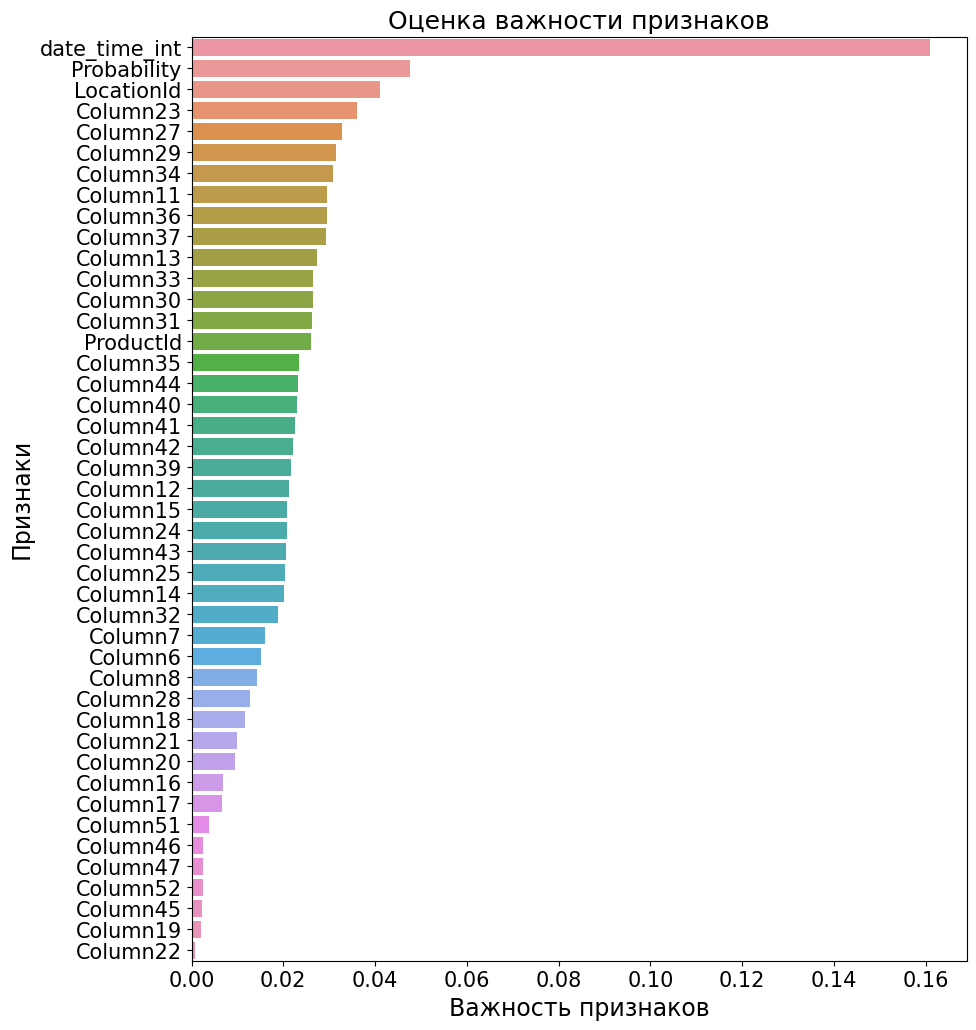

In [55]:
# построим график важности
plt.figure(figsize=(10, 12))
sns.barplot(x=X_imp_RF['feature_importance'], y=X_imp_RF.index, order=X_imp_RF.sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=18)
plt.xlabel('Важность признаков', fontsize=17)
plt.ylabel('Признаки', fontsize=17)
plt.tick_params(labelsize=15);

### CatBoost

In [56]:
# Создаем и обучаем модель CatBoost
model = CatBoostClassifier(random_state=STATE, verbose=False)
model.fit(train[X_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], model.predict_proba(test[X_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == model.predict(test[X_col]))}')

AUC-ROC на тестовых данных: 0.8147217316394428, accuracy 0.7463805895327852


In [57]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'l

In [58]:
# создадим фрейм важности признаков
X_imp_CB = pd.DataFrame({'features':X_col,'feature_importance':model.feature_importances_})
X_imp_CB = X_imp_CB.set_index('features')
X_imp_CB = X_imp_CB.sort_values('feature_importance',ascending=False)

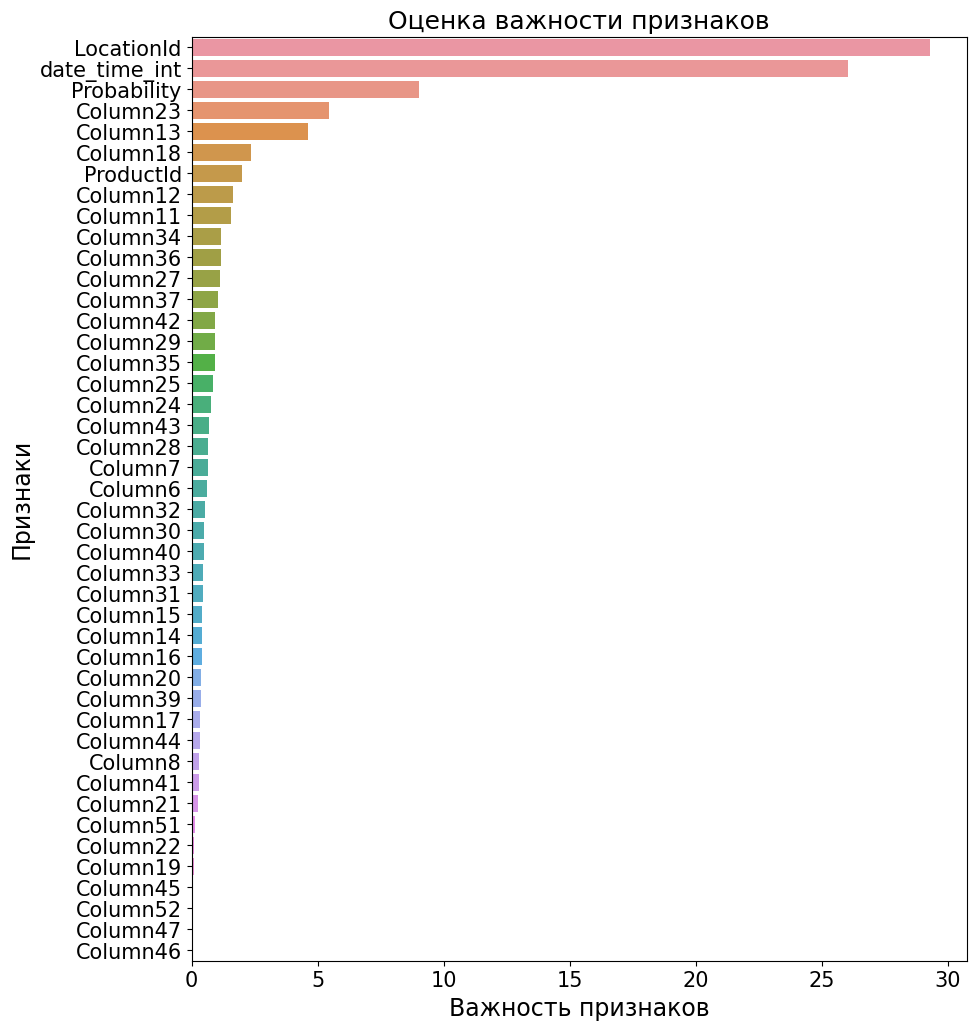

In [59]:
# построим график важности
plt.figure(figsize=(10, 12))
sns.barplot(x=X_imp_CB['feature_importance'], y=X_imp_CB.index, order=X_imp_CB.sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=18)
plt.xlabel('Важность признаков', fontsize=17)
plt.ylabel('Признаки', fontsize=17)
plt.tick_params(labelsize=15);

## Создание новых фичей

### Столбец "Час"

In [60]:
train['hour'] = train['ValidationDateTime'].dt.hour
test['hour'] = test['ValidationDateTime'].dt.hour
test_final['hour'] = test_final['ValidationDateTime'].dt.hour

### Столбец "День"

In [61]:
train['day'] = train['ValidationDateTime'].dt.day
test['day'] = test['ValidationDateTime'].dt.day
test_final['day'] = test_final['ValidationDateTime'].dt.day

### Столбец "Неделя"

In [62]:
train['week'] = train['ValidationDateTime'].dt.week
test['week'] = test['ValidationDateTime'].dt.week
test_final['week'] = test_final['ValidationDateTime'].dt.week

### Столбец "День недели"

In [63]:
train['weekday'] = train['ValidationDateTime'].dt.weekday
test['weekday'] = test['ValidationDateTime'].dt.weekday
test_final['weekday'] = test_final['ValidationDateTime'].dt.weekday

### Столбец ассортимента товара, который проверяют (количество уникальных товаров в магазине)

In [64]:
check_loc_prod_uniq = train.groupby("LocationId")["ProductId"].agg(check_loc_prod_uniq='nunique')
train = train.merge(check_loc_prod_uniq, how='left', on='LocationId')
test = test.merge(check_loc_prod_uniq, how='left', on='LocationId')
test_final = test_final.merge(check_loc_prod_uniq, how='left', on='LocationId')

### Столбец максимальной вероятности по магазину

In [65]:
max_prob_store = train.groupby('LocationId')['Probability'].agg(max_prob_store='max')
train = train.merge(max_prob_store, how='left', on='LocationId')
test = test.merge(max_prob_store, how='left', on='LocationId')
test_final = test_final.merge(max_prob_store, how='left', on='LocationId')

### Столбец средней вероятности по продукту

In [66]:
average_prob_product = train.groupby('ProductId')['Probability'].agg(average_prob_product='mean')
train = train.merge(average_prob_product, how='left', on='ProductId')
test = test.merge(average_prob_product, how='left', on='ProductId')
test_final = test_final.merge(average_prob_product, how='left', on='ProductId')

### Столбец средней вероятности по магазину

In [67]:
mean_prob_store = train.groupby('LocationId')['Probability'].agg(mean_prob_store='mean')
train = train.merge(mean_prob_store, how='left', on='LocationId')
test = test.merge(mean_prob_store, how='left', on='LocationId')
test_final = test_final.merge(mean_prob_store, how='left', on='LocationId')

### Столбец ранжирования магазина по количеству проверяемого товара (1 - магазин, где проверяют больше всего товаров)

In [68]:
train['rank_prod_check'] = train['check_loc_prod_uniq'].rank(ascending=False, method='dense')
rank_prod_check_tmp = train.groupby('LocationId')['rank_prod_check'].min().reset_index()
test = test.merge(rank_prod_check_tmp, how='left', on='LocationId')
test_final = test_final.merge(rank_prod_check_tmp, how='left', on='LocationId')

## Создание новых фичей из sales

In [69]:
# %%time
# import dask.dataframe as dd

# # Чтение и фильтрация данных
# df = dd.read_csv(SALES_FULL, dtype={'Quantity': 'float64'})
# filtered_df = df[df['Datetime'] >= '2023-06-01']

# # Выполнение вычислений
# filtered_df = filtered_df.compute()

# # Печать отфильтрованных данных
# filtered_df.shape

In [70]:
%%time
filtered_data = []

for chunk in tqdm(pd.read_csv(SALES_FULL, chunksize=100000)):
    # Преобразование столбца "Datetime" и "Date" в тип даты
    chunk['Datetime'] = pd.to_datetime(chunk['Datetime'])
    chunk['Date'] = pd.to_datetime(chunk['Date'])

    # Фильтрация данных
    filtered_chunk = chunk[(chunk['Datetime'] >= '2023-06-01') & (chunk['Datetime'] <= '2023-07-14')\
                           & (chunk['LocationId'].isin(set(train.LocationId))) & (chunk['ProductId'].isin(set(train.ProductId)))]

    # Добавление отфильтрованных данных в список
    filtered_data.append(filtered_chunk)

# Объединение отфильтрованных сегментов в один DataFrame
sales_train = pd.concat(filtered_data)

# размер фрейма
sales_train.shape

820it [02:35,  5.27it/s]


CPU times: user 2min 10s, sys: 6.26 s, total: 2min 16s
Wall time: 2min 37s


(24730659, 6)

In [71]:
description(sales_train)

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
LocationId,int64,0,0.000000,318,63,2036.000000,2950,736.876089
ProductId,int64,0,0.000000,2967,288525,425718.000000,576661,81067.518386
Datetime,datetime64[ns],0,0.000000,1033,2023-06-01 00:00:00,NaN,2023-07-14 00:00:00,12 days 09:28:41.706065336
Quantity,float64,0,0.000000,12918,-199.000000,1.000000,784.000000,2.012182
PriceSum,float64,0,0.000000,128990,-35801.000000,89.990000,108099.490000,154.031821
Date,datetime64[ns],0,0.000000,44,2023-06-01 00:00:00,NaN,2023-07-14 00:00:00,12 days 09:26:39.799589992


**Отрицательные значения в столбцах Quantity и PriceSum могут означать порчу товара, списание, брак.**

In [72]:
# поставим значение 0 для выручки, если количество продаж равно 0
sales_train.loc[sales_train['Quantity'] == 0, 'PriceSum'] = 0

In [73]:
# создаём столбец цены за 1 продукт
sales_train['price'] = (sales_train['PriceSum'] / sales_train['Quantity']).fillna(0)

# создаём столбец дне недели
sales_train['weekday'] = sales_train['Datetime'].dt.weekday

In [74]:
description(sales_train)

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
LocationId,int64,0,0.000000,318,63,2036.000000,2950,736.876089
ProductId,int64,0,0.000000,2967,288525,425718.000000,576661,81067.518386
Datetime,datetime64[ns],0,0.000000,1033,2023-06-01 00:00:00,NaN,2023-07-14 00:00:00,12 days 09:28:41.706065336
Quantity,float64,0,0.000000,12918,-199.000000,1.000000,784.000000,2.012182
PriceSum,float64,0,0.000000,128245,-35801.000000,89.990000,108099.490000,154.027682
Date,datetime64[ns],0,0.000000,44,2023-06-01 00:00:00,NaN,2023-07-14 00:00:00,12 days 09:26:39.799589992
price,float64,0,0.000000,333749,-8856.008856,66.990000,44719.908060,71.483970
weekday,int64,0,0.000000,7,0,3.000000,6,1.962333


### Столбец максимального количества проданного товара для магазина

In [75]:
max_quant_loc = sales_train.groupby('LocationId')['Quantity'].agg(max_quant_loc='max')
train = train.merge(max_quant_loc, how='left', on='LocationId')
test = test.merge(max_quant_loc, how='left', on='LocationId')
test_final = test_final.merge(max_quant_loc, how='left', on='LocationId')

### Столбец максимальной цены для магазинa

In [76]:
max_price_loc = sales_train.groupby('LocationId')['price'].agg(max_price_loc='max')
train = train.merge(max_price_loc, how='left', on='LocationId')
test = test.merge(max_price_loc, how='left', on='LocationId')
test_final = test_final.merge(max_price_loc, how='left', on='LocationId')

### Столбец средней цены для магазинa

In [77]:
mean_price_loc = sales_train.groupby('LocationId')['price'].agg(mean_price_loc='mean')
train = train.merge(mean_price_loc, how='left', on='LocationId')
test = test.merge(mean_price_loc, how='left', on='LocationId')
test_final = test_final.merge(mean_price_loc, how='left', on='LocationId')

### Столбец средней цены на продукт для магазинa

In [78]:
mean_price_loc_prod = sales_train.groupby(['LocationId', 'ProductId'])['price'].agg(mean_price_loc_prod='mean')
train = train.merge(mean_price_loc_prod, how='left', on=['LocationId', 'ProductId'])
test = test.merge(mean_price_loc_prod, how='left', on=['LocationId', 'ProductId'])
test_final = test_final.merge(mean_price_loc_prod, how='left', on=['LocationId', 'ProductId'])

### Столбец максимальной цены для продукта

In [79]:
max_price_prod = sales_train.groupby('ProductId')['price'].agg(max_price_prod='max')
train = train.merge(max_price_prod, how='left', on='ProductId')
test = test.merge(max_price_prod, how='left', on='ProductId')
test_final = test_final.merge(max_price_prod, how='left', on='ProductId')

### Столбец "время работы магазина"

In [80]:
store_open_hours_tmp = sales_train.groupby(['weekday', 'LocationId', 'Date'])['Datetime'].apply(lambda x: (x.max()-x.min()) / np.timedelta64 ( 1 , 'h')).reset_index()
store_open_hours = store_open_hours_tmp.groupby(['weekday', 'LocationId'])['Datetime'].agg(store_open_hours='max')

In [81]:
train = train.merge(store_open_hours, how='left', on=['weekday', 'LocationId'])
test = test.merge(store_open_hours, how='left', on=['weekday', 'LocationId'])
test_final = test_final.merge(store_open_hours, how='left', on=['weekday', 'LocationId'])

### Столбец среднего количества проданного товара в день

In [82]:
mean_sales_loc_day_tmp = sales_train.groupby(['LocationId', 'Date']).sum()

In [83]:
mean_quant_sales_loc_day = mean_sales_loc_day_tmp.groupby('LocationId')['Quantity'].agg(mean_quant_sales_loc_day='mean')
train = train.merge(mean_quant_sales_loc_day, how='left', on='LocationId')
test = test.merge(mean_quant_sales_loc_day, how='left', on='LocationId')
test_final = test_final.merge(mean_quant_sales_loc_day, how='left', on='LocationId')

### Столбец средней суммы проданного товара по магазину в день

In [84]:
mean_sum_sales_loc_day = mean_sales_loc_day_tmp.groupby('LocationId')['PriceSum'].agg(mean_sum_sales_loc_day='mean')
train = train.merge(mean_sum_sales_loc_day, how='left', on='LocationId')
test = test.merge(mean_sum_sales_loc_day, how='left', on='LocationId')
test_final = test_final.merge(mean_sum_sales_loc_day, how='left', on='LocationId')

### Столбец "среднее количество уникальных товаров, проданных за день в определенном магазине"

In [85]:
prod_range_loc_day_tmp = sales_train.groupby(['LocationId', 'Date']).nunique()

In [86]:
prod_range_loc_day = prod_range_loc_day_tmp.groupby('LocationId')['ProductId'].agg(prod_range_loc_day='mean')
train = train.merge(prod_range_loc_day, how='left', on='LocationId')
test = test.merge(prod_range_loc_day, how='left', on='LocationId')
test_final = test_final.merge(prod_range_loc_day, how='left', on='LocationId')

### Столбец ранга товара (1 - самый продаваемый)

In [87]:
rank_prod = sales_train.groupby('ProductId').sum()
rank_prod['rank_prod_sales'] = rank_prod['Quantity'].rank(ascending=False, method='dense')
train = train.merge(rank_prod['rank_prod_sales'], on='ProductId', how='left')
test = test.merge(rank_prod['rank_prod_sales'], on='ProductId', how='left')
test_final = test_final.merge(rank_prod['rank_prod_sales'], on='ProductId', how='left')

## Создание новых фичей из stocks

In [88]:
%%time
filtered_data = []

for chunk in tqdm(pd.read_csv(STOCKS_FULL, chunksize=100000)):
    # Преобразование столбца "Datetime" и "Date" в тип даты
    chunk['Datetime'] = pd.to_datetime(chunk['Datetime'])
    chunk['Date'] = pd.to_datetime(chunk['Date'])

    # Фильтрация данных
    filtered_chunk = chunk[(chunk['Datetime'] >= '2023-06-01')\
                           & (chunk['LocationId'].isin(set(train.LocationId))) & (chunk['ProductId'].isin(set(train.ProductId)))]

    # Добавление отфильтрованных данных в список
    filtered_data.append(filtered_chunk)

# Объединение отфильтрованных сегментов в один DataFrame
stocks_train = pd.concat(filtered_data)

# размер фрейма
stocks_train.shape

1134it [03:02,  6.22it/s]


CPU times: user 2min 40s, sys: 7.16 s, total: 2min 48s
Wall time: 3min 5s


(42856940, 5)

In [89]:
description(stocks_train)

,Тип данных,Кол-во пропусков,Процент пропусков,Кол-во уникальных,MIN,Медиана,MAX,STD
LocationId,int64,0,0.000000,318,63,2016.000000,2950,776.001108
ProductId,int64,0,0.000000,2967,288525,426593.000000,576661,81581.810887
Datetime,datetime64[ns],0,0.000000,1654,2023-06-01 00:51:21.010000,NaN,2023-08-04 23:51:22.170000,18 days 17:33:37.139018789
Quantity,float64,0,0.000000,37370,-10132.000000,14.000000,10672.000000,67.977934
Date,datetime64[ns],0,0.000000,65,2023-06-01 00:00:00,NaN,2023-08-04 00:00:00,18 days 17:29:12.509465834


In [90]:
stocks_train.head()

,LocationId,ProductId,Datetime,Quantity,Date
35876310,63,288527,2023-06-01 00:51:21.010,146.000000,2023-06-01
35876311,63,288606,2023-06-01 00:51:21.010,15.000000,2023-06-01
35876312,63,288783,2023-06-01 00:51:21.010,4.000000,2023-06-01
35876313,63,288817,2023-06-01 00:51:21.010,10.000000,2023-06-01
35876315,63,288917,2023-06-01 00:51:21.010,23.000000,2023-06-01


### Столбец ассортимента товара на складе (количество уникальных товаров в магазине)

In [91]:
product_range_stocks = stocks_train.groupby("LocationId")["ProductId"].agg(product_range_stocks='nunique')
train = train.merge(product_range_stocks, how='left', on='LocationId')
test = test.merge(product_range_stocks, how='left', on='LocationId')
test_final = test_final.merge(product_range_stocks, how='left', on='LocationId')

### Столбец разницы между товаром на складе и товаром для проверки

In [92]:
train['diff_prod_range'] = train['product_range_stocks'] - train['check_loc_prod_uniq']
test['diff_prod_range'] = test['product_range_stocks'] - test['check_loc_prod_uniq']
test_final['diff_prod_range'] = test_final['product_range_stocks'] - test_final['check_loc_prod_uniq']

### Столбец "уникальность товара" (в каком количестве магазинов присутствует тот или иной товар)

In [93]:
prod_uniq_loc = train.groupby("ProductId")["LocationId"].agg(prod_uniq_loc='nunique')
train = train.merge(prod_uniq_loc, how='left', on='ProductId')
test = test.merge(prod_uniq_loc, how='left', on='ProductId')
test_final = test_final.merge(prod_uniq_loc, how='left', on='ProductId')

**Посмотрим, как часто приходит товар.**

In [94]:
stocks_train = stocks_train.sort_values(['LocationId', 'Date'])
stocks_sum_quant = stocks_train.groupby(['LocationId', 'Date'])['Quantity'].agg(Quantity_sum='sum')
stocks_sum_quant['Quantity_diff'] = stocks_sum_quant['Quantity_sum'].diff()

In [95]:
stocks_sum_quant.head(10)

Quantity_sum  Quantity_diff
LocationId Date                                   
63         2023-06-01  47359.218000            NaN
           2023-06-02  46451.814000    -907.404000
           2023-06-03  47939.633000    1487.819000
           2023-06-04  46058.392000   -1881.241000
           2023-06-05  47546.331000    1487.939000
           2023-06-06  45709.623000   -1836.708000
           2023-06-07  48921.591000    3211.968000
           2023-06-08  51014.324000    2092.733000
           2023-06-09  48910.943000   -2103.381000
           2023-06-10  50537.086000    1626.143000

In [96]:
stocks_sum_quant[stocks_sum_quant['Quantity_diff'] > 0].head(10)

Quantity_sum  Quantity_diff
LocationId Date                                   
63         2023-06-03  47939.633000    1487.819000
           2023-06-05  47546.331000    1487.939000
           2023-06-07  48921.591000    3211.968000
           2023-06-08  51014.324000    2092.733000
           2023-06-10  50537.086000    1626.143000
           2023-06-12  50914.308000    2185.644000
           2023-06-14  49899.808000    1053.410000
           2023-06-16  49649.469000    1736.621000
           2023-06-18  49934.561000    2321.191000
           2023-06-20  48651.530000     875.818000

**Мы видим, что заказы приходят раз в два дня, даже чаще. Нет смысла создавать отдельную колонку.**

In [97]:
# заполним появившиеся пропуски
X_col = train.drop(columns=['IsCorrect', 'ValidationDateTime']).columns.tolist()
imputer = SimpleImputer(strategy='median')
train[X_col] = imputer.fit_transform(train[X_col])
test[X_col] = imputer.transform(test[X_col])
test_final[X_col] = imputer.transform(test_final[X_col])

In [98]:
test.isna().sum().sum()

0

In [99]:
model = CatBoostClassifier(random_state=STATE, verbose=False)
model.fit(train[X_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], model.predict_proba(test[X_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == model.predict(test[X_col]))}')

AUC-ROC на тестовых данных: 0.8512430211422745, accuracy 0.7805895327852417


In [100]:
# создадим фрейм важности признаков
X_imp_CB = pd.DataFrame({'features':X_col,'feature_importance':model.feature_importances_})
X_imp_CB = X_imp_CB.set_index('features')
X_imp_CB = X_imp_CB.sort_values('feature_importance',ascending=False)

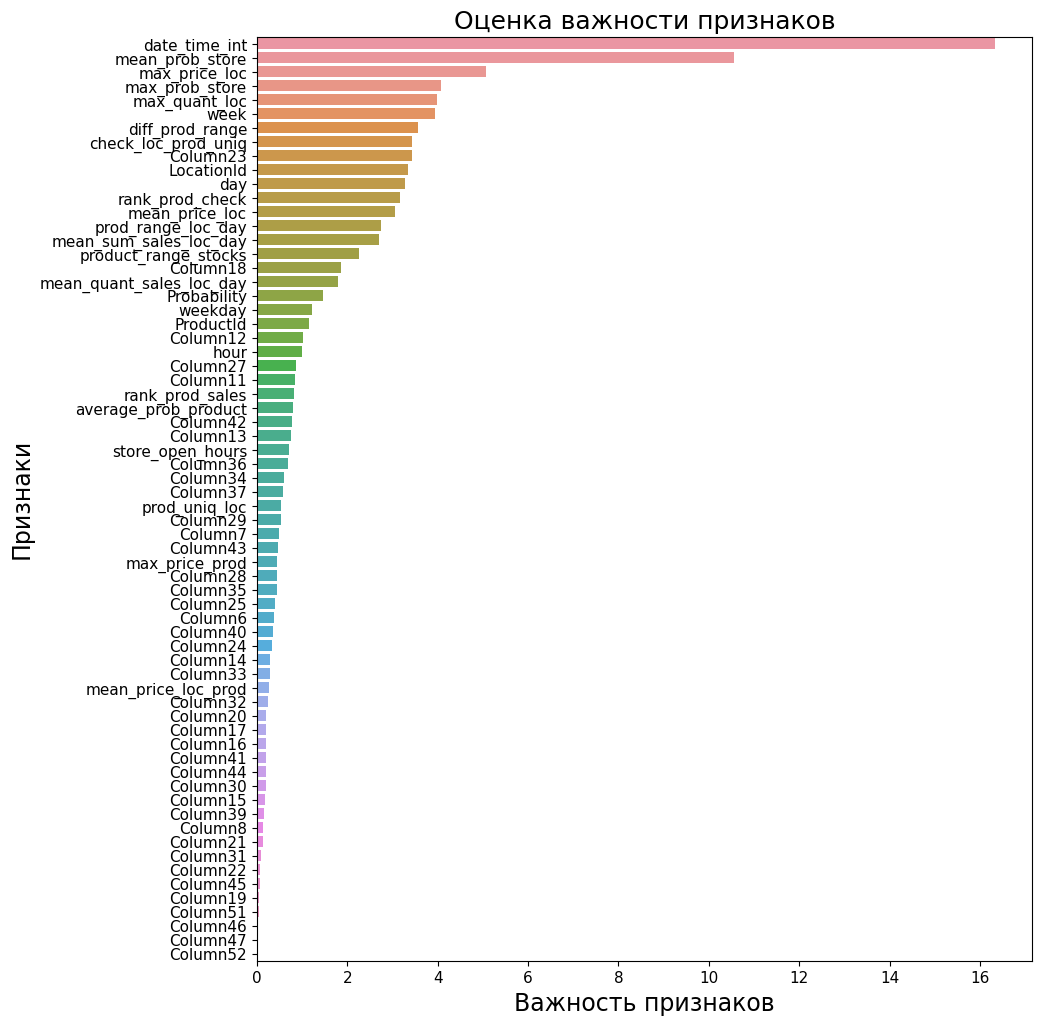

In [101]:
# построим график важности
plt.figure(figsize=(10, 12))
sns.barplot(x=X_imp_CB['feature_importance'], y=X_imp_CB.index, order=X_imp_CB.sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=18)
plt.xlabel('Важность признаков', fontsize=17)
plt.ylabel('Признаки', fontsize=17)
plt.tick_params(labelsize=11);

In [102]:
len(X_imp_CB)

66

In [103]:
# приведём к int столбцы с целыми числами, имеющими тип float
is_float = train.select_dtypes(include=['float']).columns.tolist()
is_int = train[is_float].apply(lambda x: x.astype(int) == x).all()
int_col = is_int[is_int].index.tolist()
train[int_col] = train[int_col].astype(int)
test[int_col] = test[int_col].astype(int)
test_final[int_col] = test_final[int_col].astype(int)

## Моделирование с новыми колонками

In [104]:
X_col = train.drop(columns=['IsCorrect', 'ValidationDateTime']).columns.tolist()

In [105]:
%%time
model_RF = RandomForestClassifier(random_state=STATE)
model_RF.fit(train[X_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], model_RF.predict_proba(test[X_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == model_RF.predict(test[X_col]))}')

AUC-ROC на тестовых данных: 0.8326798781450365, accuracy 0.7671144976940044
CPU times: user 1min 20s, sys: 122 ms, total: 1min 20s
Wall time: 1min 20s


In [106]:
%%time
model = CatBoostClassifier(random_state=STATE, verbose=False)
model.fit(train[X_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], model.predict_proba(test[X_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == model.predict(test[X_col]))}')

AUC-ROC на тестовых данных: 0.8512430211422745, accuracy 0.7805895327852417
CPU times: user 1min 33s, sys: 2.26 s, total: 1min 35s
Wall time: 1min 4s


## feature_selection

**При выборе столбцов для обучения были использованы: select_features CatBoost, BorutaPy, arfsgroot, SequentialFeatureSelector, RFECV, ExhaustiveFeatureSelector, SelectFromModel, shap. Лучшим результатом оказался метод select_features от CatBoost**

### Подбор признаков с использованием метода select_features CatBoost

In [107]:
train_pool = Pool(train[X_col], train[y_col], feature_names=X_col)
test_pool = Pool(test[X_col], test[y_col], feature_names=X_col)

In [108]:
def select_features_CB(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model_sf = CatBoostClassifier(iterations=500, random_state=STATE, eval_metric='AUC')
    summary = model_sf.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=X_col,
        num_features_to_select=38,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Exact,
        train_final_model=False,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [109]:
%%time
shap_summary = select_features_CB(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost is using more CPU RAM (8.54GiB) than the limit (4.14GiB)
CatBoost is using more CPU RAM (8.54GiB) than the limit (4.14GiB)
CatBoost is using more CPU RAM (8.56GiB) than the limit (4.12GiB)
CatBoost is using more CPU RAM (8.56GiB) than the limit (4.12GiB)
CatBoost is using more CPU RAM (8.57GiB) than the limit (4.11GiB)
CatBoost is using more CPU RAM (8.57GiB) than the limit (4.11GiB)
CatBoost is using more CPU RAM (8.57GiB) than the limit (4.11GiB)
CatBoost is using more CPU RAM (8.57GiB) than the limit (4.11GiB)


Selected features: ['ProductId', 'Probability', 'Column7', 'Column8', 'Column11', 'Column12', 'Column14', 'Column16', 'Column18', 'Column19', 'Column21', 'Column22', 'Column23', 'Column27', 'Column30', 'Column31', 'Column32', 'Column33', 'Column37', 'Column39', 'Column44', 'Column45', 'Column46', 'Column47', 'Column51', 'Column52', 'date_time_int', 'hour', 'week', 'check_loc_prod_uniq', 'max_prob_store', 'mean_prob_store', 'rank_prod_check', 'max_price_loc', 'mean_price_loc_prod', 'max_price_prod', 'mean_sum_sales_loc_day', 'prod_uniq_loc']
CPU times: user 2min 42s, sys: 9.23 s, total: 2min 51s
Wall time: 1min 59s


In [110]:
best_col = shap_summary.get('selected_features_names')

In [111]:
%%time
model = CatBoostClassifier(random_state=STATE, verbose=False)
model.fit(train[best_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], model.predict_proba(test[best_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == model.predict(test[best_col]))}')

AUC-ROC на тестовых данных: 0.860763597376046, accuracy 0.7815119310206537
CPU times: user 1min 10s, sys: 2.21 s, total: 1min 12s
Wall time: 47.1 s


In [112]:
%%time
model_RF = RandomForestClassifier(random_state=STATE)
model_RF.fit(train[best_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], model_RF.predict_proba(test[best_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == model_RF.predict(test[best_col]))}')

AUC-ROC на тестовых данных: 0.8401883977476936, accuracy 0.7732504511730499
CPU times: user 1min 2s, sys: 104 ms, total: 1min 2s
Wall time: 1min 2s


## Ансамбль моделей

In [113]:
randomforest_model = RandomForestClassifier(random_state=STATE)
lgbm_model = LGBMClassifier(random_state=STATE, verbose=-1, learning_rate=0.18, n_estimators=115, )
catboost_model = CatBoostClassifier(random_state=STATE, verbose=False)

In [114]:
ensemble_model = VotingClassifier(
    estimators=[
        ('randomforest', randomforest_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ],
    voting='soft'
)

In [115]:
%%time
ensemble_model.fit(train[best_col], train[y_col])
roc_auc = roc_auc_score(test[y_col], ensemble_model.predict_proba(test[best_col])[:, 1])
print(f'AUC-ROC на тестовых данных: {roc_auc}, accuracy {np.mean(test[y_col] == ensemble_model.predict(test[best_col]))}')

AUC-ROC на тестовых данных: 0.8569491349599133, accuracy 0.7821134950872268
CPU times: user 2min 12s, sys: 2.59 s, total: 2min 15s
Wall time: 1min 53s


**Ансамбль моделей немного улучшил accuracy, но не улучшил auc-roc.**

## ROC-кривая

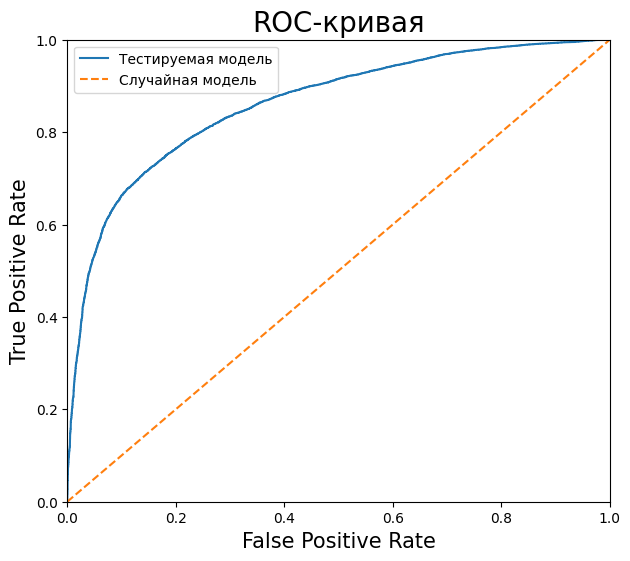

In [116]:
fpr, tpr, thresholds = roc_curve(test[y_col], model.predict_proba(test[best_col])[:, 1])

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
#   установим границы осей от 0 до 1 >
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC-кривая', fontsize=20)
plt.legend(('Тестируемая модель', 'Случайная модель'), loc= 'upper left')
plt.show()

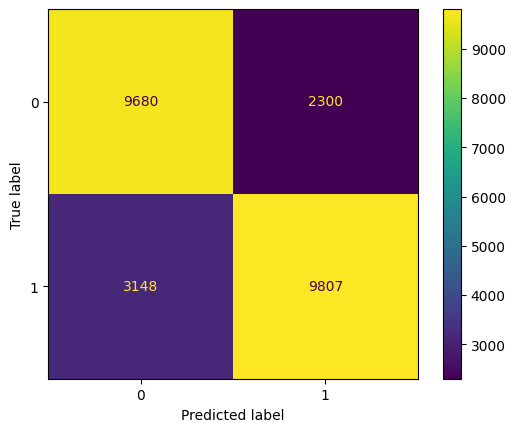

In [117]:
cm = confusion_matrix(test[y_col], model.predict(test[best_col]))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [118]:
# Предсказание вероятности наличия товара на полке на тестовом наборе
test_final['CalculatedProbability'] = model.predict_proba(test_final[best_col])[:, 1]

In [119]:
test_final[['LocationId',
           'ProductId',
           'ValidationDateTime',
           'CalculatedProbability']].to_csv('/content/gdrive/MyDrive/GoodsForecastHack/Podval_final.csv',
                                            sep=';',
                                            index=False)

# Вывод

По предоставленным заказчиком данным были изучены данные торговой сети, содержащие временные метки по магазинам и товарным позициям, в момент которых выявлялись наличия пустых полок, вероятность данного события, вычисленная заказчиком, а также признаки.<br>
Были выявлены и устранены множественные пропуски с помощью устранение неинформативных признаков и заполнения медианным значением.    
При выборе столбцов для обучения были использованы: select_features CatBoost, BorutaPy, arfsgroot, SequentialFeatureSelector, RFECV, ExhaustiveFeatureSelector, SelectFromModel, shap. Лучшим результатом оказался метод select_features от CatBoost.       
В качестве модели машинного обучения использовались модели RandomForest и CatBoost с ручным подбором гиперпараметров. Построена матрица ошибок, для контроля выявления именно отсутвия товара на полке, а не наличия, а также контроля ошибок модели.<br>
Метрика AUC-ROC данной модели на валидационной выборке составила 0.860763597376046